In [2]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# Load the data
df = pd.read_csv('train.csv')

# Display first few rows
df.head()

,InvoiceId,Date,CustomerId,ProductId,Quantity,Amount
0,1707809,2021-01-04,D-443485,P-62587,1.0,160.4
1,1707809,2021-01-04,D-443485,P-62587,2.0,392.6
2,1716836,2021-01-08,D-370410,P-62587,10.0,70.0
3,1716836,2021-01-08,D-370410,P-62587,10.0,36.0
4,1716836,2021-01-08,D-370410,P-62587,10.0,1521.5


In [4]:
# Calculate summary statistics of the DataFrame
df.describe

<bound method NDFrame.describe of         InvoiceId                 Date CustomerId  ProductId  Quantity  Amount
0         1707809           2021-01-04   D-443485    P-62587       1.0   160.4
1         1707809           2021-01-04   D-443485    P-62587       2.0   392.6
2         1716836           2021-01-08   D-370410    P-62587      10.0    70.0
3         1716836           2021-01-08   D-370410    P-62587      10.0    36.0
4         1716836           2021-01-08   D-370410    P-62587      10.0  1521.5
...           ...                  ...        ...        ...       ...     ...
175509    3116849  2023-12-01 00:00:00   D-664689      P-167       5.0   869.0
175510    3119916  2023-12-08 00:00:00    D-17961  P-2866526       2.0   250.0
175511    3119916  2023-12-08 00:00:00    D-17961   P-852775       1.0   331.2
175512    3125718  2023-12-25 00:00:00    D-17440      P-213       2.0   300.0
175513    3125718  2023-12-25 00:00:00    D-17440      P-215       2.0  1710.0

[175514 rows x 6 

In [62]:
# Get the dimensions of the DataFrame (rows, columns)
df.shape

(175514, 6)

In [5]:
# Print concise summary of the DataFrame's structure
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175514 entries, 0 to 175513
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   InvoiceId   175514 non-null  int64  
 1   Date        175514 non-null  object 
 2   CustomerId  175514 non-null  object 
 3   ProductId   175130 non-null  object 
 4   Quantity    175130 non-null  float64
 5   Amount      175130 non-null  float64
dtypes: float64(2), int64(1), object(3)
memory usage: 8.0+ MB


In [9]:
# Check for null values
print(df.isnull().sum())  # Calculate the number of null values in each column
print((df.isnull().sum()/(len(df)))*100)  # Calculate the percentage of null values in each column

df = df.dropna()  # Remove rows with missing values

print(df.isnull().sum()) 

InvoiceId     0
Date          0
CustomerId    0
ProductId     0
Quantity      0
Amount        0
dtype: int64
InvoiceId     0.0
Date          0.0
CustomerId    0.0
ProductId     0.0
Quantity      0.0
Amount        0.0
dtype: float64
InvoiceId     0
Date          0
CustomerId    0
ProductId     0
Quantity      0
Amount        0
dtype: int64


In [11]:
# Check for duplicated values
print(df.duplicated().any())  # Check if there are any duplicate rows

df = df.drop_duplicates()  # Remove duplicate rows

print(df.duplicated().any())  # Verify that there are no more duplicate rows
print(df.nunique())  # Check the number of unique values in each column

False
False
InvoiceId     57315
Date           1608
CustomerId      883
ProductId       231
Quantity        298
Amount         6616
dtype: int64


In [23]:
# Remove negative values
df = df[df['Quantity'] >= 1]  # Keep only rows with non-negative quantities
df = df[df['Amount'] >= 1]  # Keep only rows with non-negative amounts

# Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'], format='mixed')

# Sort the DataFrame by date in ascending order
df.sort_values(by='Date', inplace=True)

# Extract year, month, and quarter from the date
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Quarter'] = df['Date'].dt.quarter

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 162058 entries, 129889 to 109313
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   InvoiceId   162058 non-null  int64         
 1   Date        162058 non-null  datetime64[ns]
 2   CustomerId  162058 non-null  object        
 3   ProductId   162058 non-null  object        
 4   Quantity    162058 non-null  float64       
 5   Amount      162058 non-null  float64       
 6   Year        162058 non-null  int32         
 7   Month       162058 non-null  int32         
 8   Quarter     162058 non-null  int32         
dtypes: datetime64[ns](1), float64(2), int32(3), int64(1), object(2)
memory usage: 10.5+ MB


In [14]:
from sklearn.preprocessing import LabelEncoder

# Encode CustomerID and ProductID
le_cust = LabelEncoder()
df['CustomerId'] = le_cust.fit_transform(df['CustomerId'])

# Create a mapping for original and encoded CustomerIDs
customer_mapping = pd.DataFrame({
    'OriginalCustomerId': le_cust.classes_,
    'EncodedCustomerId': range(len(le_cust.classes_))
})

le_prod = LabelEncoder()
df['ProductId'] = le_prod.fit_transform(df['ProductId'])

# Create a mapping for original and encoded ProductIDs
product_mapping = pd.DataFrame({
    'OriginalProductId': le_prod.classes_,
    'EncodedProductId': range(len(le_prod.classes_))
})

# Aggregate data by product, summing quantity and amount
product_sales = df.groupby('ProductId').agg({'Quantity': 'sum', 'Amount': 'sum'}).reset_index()

# Find the top 10 products by quantity sold
top_products = product_sales.sort_values(by='Quantity', ascending=False).head(10)

# Map encoded ProductIDs back to original product names
top_products = top_products.merge(product_mapping, left_on='ProductId', right_on='EncodedProductId', how='left')

In [ ]:
# Function to combine orders
def combine_orders_within_window(df, time_window_days):
    # Sort by 'CustomerId' and 'Date'
    df = df.sort_values(by=['CustomerId', 'Date'])
    
    combined_orders = []
    
    for customer_id, group in df.groupby('CustomerId'):
        group = group.reset_index(drop=True)
        start_idx = 0
        
        while start_idx < len(group):
            end_idx = start_idx + 1
            
            # Find end of window
            while end_idx < len(group) and (group.loc[end_idx, 'Date'] - group.loc[start_idx, 'Date']).days <= time_window_days:
                end_idx += 1
                
            # Combine orders in the window
            window_orders = group.iloc[start_idx:end_idx]
            combined_order = window_orders.copy()
            combined_order = combined_order.groupby('ProductId').agg({
                'Quantity': 'sum',
                'Amount': 'sum'
            }).reset_index()
            
            # Add the customer ID and the start date of the window
            combined_order['CustomerId'] = customer_id
            combined_order['StartDate'] = group.loc[start_idx, 'Date']
            combined_order['Year'] = group.loc[start_idx, 'Year']  # Add Year
            combined_order['Month'] = group.loc[start_idx, 'Month']  # Add Month
            combined_orders.append(combined_order)
            
            start_idx = end_idx
            # Concatenate all combined orders
    result_df = pd.concat(combined_orders, ignore_index=True)
    
    return result_df

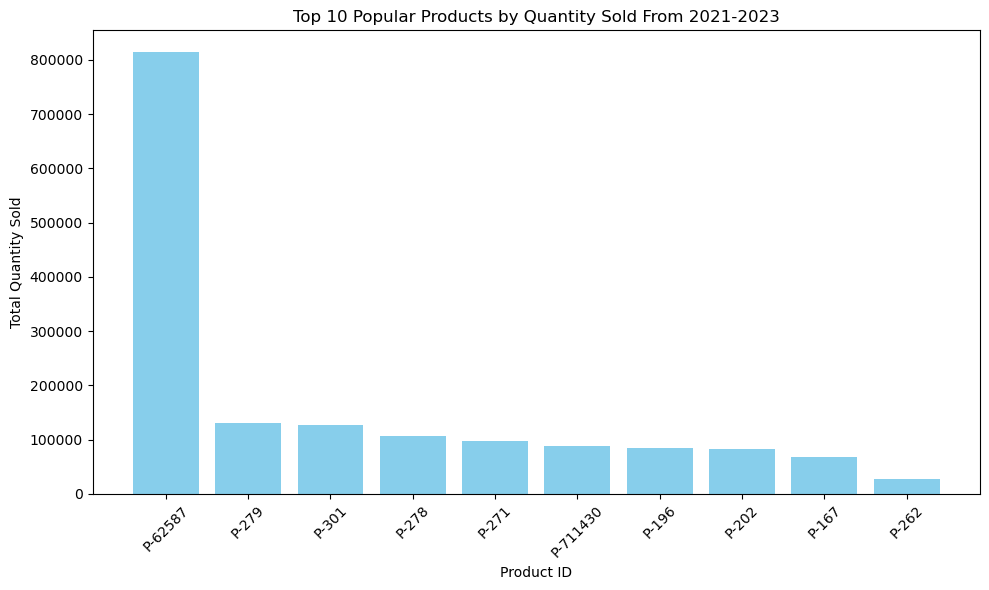

In [16]:
# Plot the graph using original product names
plt.figure(figsize=(10, 6))  # Create a figure with desired dimensions
plt.bar(top_products['OriginalProductId'], top_products['Quantity'], color='skyblue')  # Create bar chart
plt.title('Top 10 Popular Products by Quantity Sold From 2021-2023')  # Set plot title
plt.xlabel('Product ID')  # Label x-axis
plt.ylabel('Total Quantity Sold')  # Label y-axis
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust spacing to prevent overlapping elements

# Display the plot
plt.show()

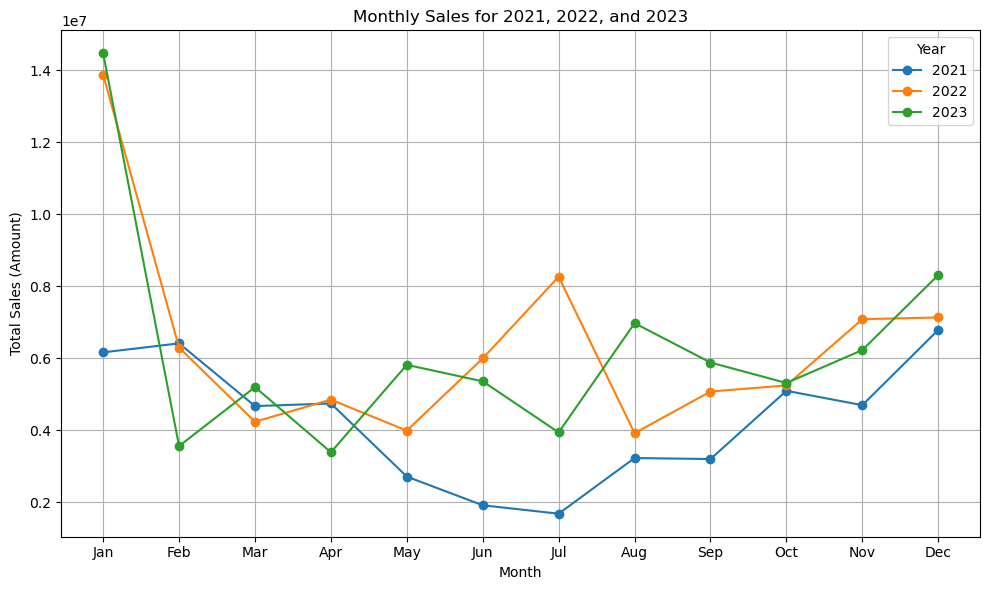

In [17]:
# Analyze monthly sales
monthly_sales = df.groupby(['Year', 'Month']).agg({'Amount': 'sum'}).reset_index()  # Group and aggregate data by year and month
monthly_sales_pivot = monthly_sales.pivot(index='Month', columns='Year', values='Amount')  # Create pivot table for monthly sales across years

# Create timeseries plot for monthly sales
plt.figure(figsize=(10, 6))  # Create a figure with desired dimensions
plt.plot(monthly_sales_pivot.index, monthly_sales_pivot[2021], label='2021', marker='o')  # Plot monthly sales for 2021
plt.plot(monthly_sales_pivot.index, monthly_sales_pivot[2022], label='2022', marker='o')  # Plot monthly sales for 2022
plt.plot(monthly_sales_pivot.index, monthly_sales_pivot[2023], label='2023', marker='o')  # Plot monthly sales for 2023

# Customize the plot
plt.title('Monthly Sales for 2021, 2022, and 2023')  # Set plot title
plt.xlabel('Month')  # Label x-axis
plt.ylabel('Total Sales (Amount)')  # Label y-axis
plt.xticks(monthly_sales_pivot.index, ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])  # Set custom month labels
plt.legend(title='Year')  # Add legend
plt.grid(True)  # Display gridlines for better visualization
plt.tight_layout()  # Adjust spacing to prevent overlapping elements

# Display the plot
plt.show()

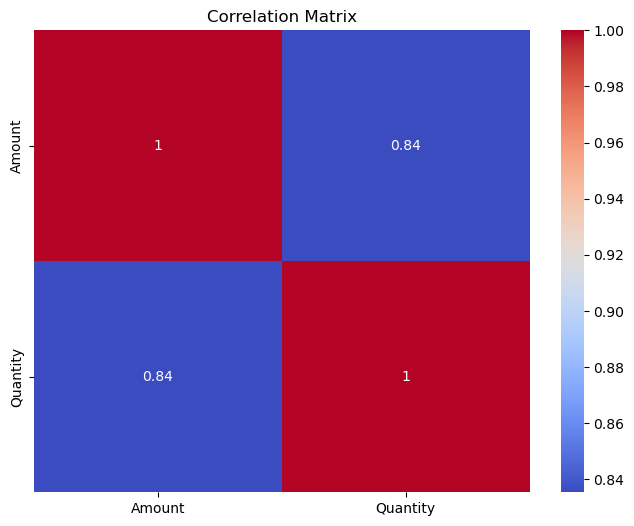

In [18]:
import seaborn as sns

# Calculate correlation matrix
correlation_matrix = df[['Amount', 'Quantity']].corr()

# Create heatmap to visualize correlation
plt.figure(figsize=(8, 6))  # Set figure size
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')  # Create heatmap with annotations and colormap
plt.title('Correlation Matrix')  # Set plot title
plt.show()  # Display the plot

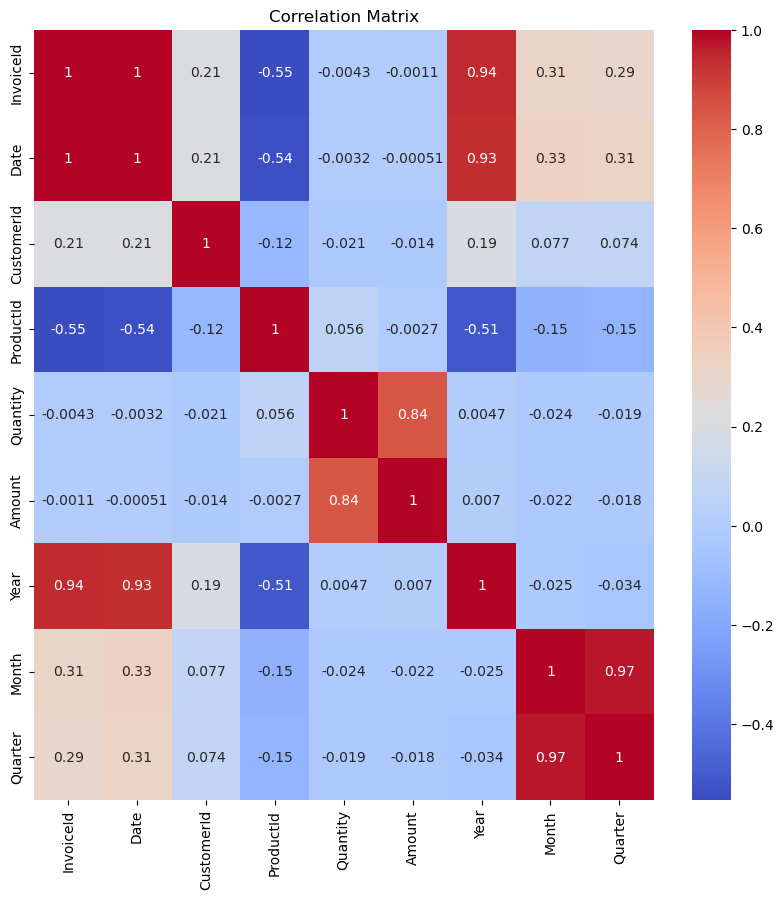

In [19]:
# Calculate the correlation matrix for all numerical columns in the DataFrame
corr_matrix = df.corr()

# Create a heatmap to visualize the correlations
plt.figure(figsize=(10, 10))  # Set figure size
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')  # Create heatmap with annotations and colormap
plt.title('Correlation Matrix')  # Set plot title
plt.show()  # Display the plot

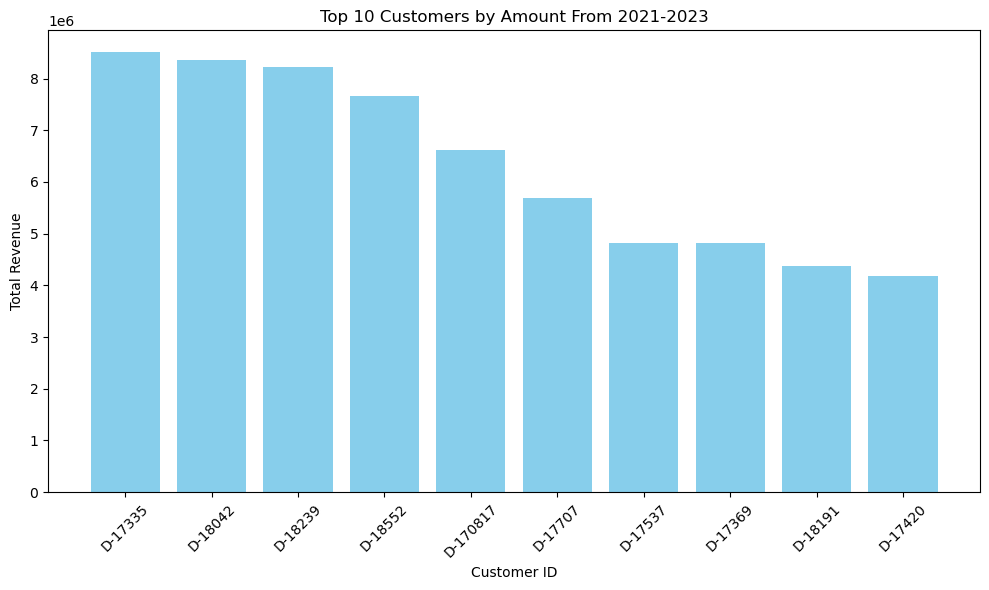

In [20]:
# Identify top customers by total spending
top_customer = df.groupby('CustomerId')['Amount'].sum().reset_index(name='Amount')  # Group by customer and sum amount spent

# Round amount spent to 3 decimal places for better presentation (optional)
top_customer = top_customer[['CustomerId', 'Amount']].round(3)  # Round amount spent values

# Reset index to create separate columns for customer and amount
top_customer.reset_index(inplace=True)  # Reset index for easier manipulation

# Sort by total spending (descending) and select top 10 customers
top_customer = top_customer.sort_values(by='Amount', ascending=False).head(10)  # Sort by amount spent (highest first) and select top 10

# Map encoded customer IDs back to original names
top_customer = top_customer.merge(customer_mapping, left_on='CustomerId', right_on='EncodedCustomerId', how='left')  # Merge with mapping to get original customer IDs

# Plot the graph using original customer names
plt.figure(figsize=(10, 6))  # Create a figure with desired dimensions
plt.bar(top_customer['OriginalCustomerId'], top_customer['Amount'], color='skyblue')  # Create bar chart
plt.title('Top 10 Customers by Amount From 2021-2023')  # Set plot title
plt.xlabel('Customer ID')  # Label x-axis
plt.ylabel('Total Revenue')  # Label y-axis
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust spacing to prevent overlapping elements

# Display the plot
plt.show()

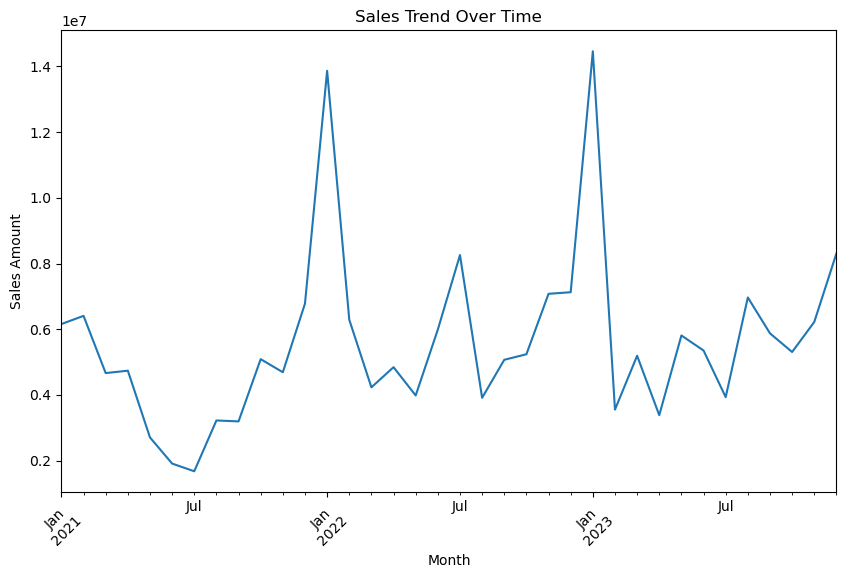

In [22]:
# Convert 'Date' to datetime if necessary (assuming it's not already datetime)
df['Date'] = pd.to_datetime(df['Date'])

# Group data by month start and sum sales amount
monthly_sales = df.groupby(pd.Grouper(key='Date', freq='MS'))['Amount'].sum()

# Create a line chart to visualize sales trend
plt.figure(figsize=(10, 6))
monthly_sales.plot(kind='line')
plt.title('Sales Trend Over Time')
plt.xlabel('Month')
plt.ylabel('Sales Amount')
plt.xticks(rotation=45)
plt.show()